# Cluster inspection: archetypes visualizations

This notebook loads the aggregated per-player `data/player_archetypes.csv` created by the pipeline and produces a set of visualizations to inspect cluster structure and the features that separate archetypes.

Visualizations included:
- PCA scatter (2D) colored by cluster
- Cluster centroid heatmap (z-scored features)
- Top feature bars per cluster (top 5 distinguishing features)
- Feature distribution plots (launch speed, pct_hard_hit, launch angle)
- Pairplot sample for feature relationships

Run the cells in order. If your outputs are in a different path, change the paths in the first code cell.

In [15]:
# Cell 2: imports and plotting settings
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

sns.set(style='whitegrid', palette='tab10')
%matplotlib inline

In [17]:
# Cell 3: paths and load data (use cleaned player_archetypes.csv created by the pipeline)
base = Path('.')
players_fp = base / 'Users' / 'christopherhsu' / 'projects' / 'hitterarchetypes' / 'data' / 'player_archetypes.csv'
diagnostics_fp = base / 'out' / 'cluster_plots' / 'diagnostics.json'

assert players_fp.exists(), f'player file not found: {players_fp}'
df = pd.read_csv(players_fp)
print('Loaded', len(df), 'players')

# try to load diagnostics (optional) to pick the feature list used by the pipeline
if diagnostics_fp.exists():
    with diagnostics_fp.open() as fh:
        diags = json.load(fh)
    features = diags.get('params', {}).get('features', None)
    print('Diagnostics features from pipeline:', features)
else:
    diags = None
    features = None

# determine numeric features to use for PCA/clustering inspection
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
# prefer pipeline features list if available and present in the dataframe
if features is not None:
    features = [f for f in features if f in numeric]
else:
    # heuristic: keep numeric clustering features and drop id/cluster columns
    features = [c for c in numeric if c not in ['cluster', 'cluster_k5', 'cluster_k3', 'n_swings']]

print('Using features:', features)

AssertionError: player file not found: Users/christopherhsu/projects/hitterarchetypes/data/player_archetypes.csv

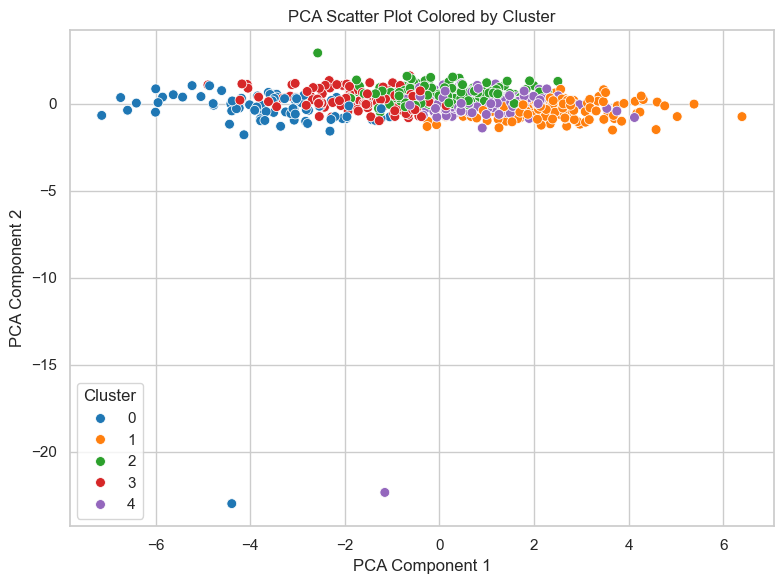

In [20]:
# Visualize clusters using PCA scatter plot (2D)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_col = [c for c in ['cluster', 'cluster_k5', 'cluster_k3'] if c in df.columns][0]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df[cluster_col], palette='tab10', s=50)
plt.title('PCA Scatter Plot Colored by Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# PCA visualizations: percentile-zoomed plot + full plot with outliers highlighted
from sklearn.preprocessing import RobustScaler
# Use RobustScaler on the features (the pipeline already cleaned them, but we scale for plotting consistency)
X = df[features].fillna(0.0)
scaler = RobustScaler()
Xs = scaler.fit_transform(X.values)
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(Xs)
pcdf = pd.DataFrame(pcs, columns=['PC1','PC2'])
pcdf['cluster'] = df[cluster_col].astype(str).values

# robust outlier detection (median/MAD on features)
med = df[features].median()
mad = df[features].apply(lambda x: (x - x.median()).abs().median())
stds = df[features].std()
mad2 = mad.copy()
for c in mad2.index:
    if mad2[c] == 0 or pd.isna(mad2[c]):
        mad2[c] = stds[c] if stds[c] > 0 else 1.0
rob_z = (df[features] - med) / mad2
maxabs = rob_z.abs().max(axis=1)
# mark outliers using a threshold (e.g., > 5 MADs)
outlier_mask = maxabs > 5.0
out_idx = df.loc[outlier_mask].index

# Plot: left = zoomed to 1-99 percentile; right = full with outliers highlighted
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(14,6))
# left: percentile-limited view
xlo, xhi = np.percentile(pcdf['PC1'], [1,99])
ylo, yhi = np.percentile(pcdf['PC2'], [1,99])
sns.scatterplot(ax=axes[0], data=pcdf, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.8)
axes[0].set_xlim(xlo, xhi); axes[0].set_ylim(ylo, yhi)
axes[0].set_title('PCA (zoomed to 1-99 percentile)')
# right: full view, highlight outliers
sns.scatterplot(ax=axes[1], data=pcdf, x='PC1', y='PC2', hue='cluster', palette='tab10', s=20, alpha=0.4, legend=False)
if len(out_idx):
    axes[1].scatter(pcdf.loc[out_idx,'PC1'], pcdf.loc[out_idx,'PC2'], facecolors='none', edgecolors='r', s=120, linewidths=1.5)
    # annotate outliers with player id (and name if available)
    for i in out_idx:
        pid = int(df.loc[i, 'batter']) if 'batter' in df.columns else str(i)
        label = str(pid)
        if 'name' in df.columns and pd.notna(df.loc[i,'name']):
            label = f'{label} {df.loc[i,'name']}'
        axes[1].text(pcdf.loc[i,'PC1'], pcdf.loc[i,'PC2'], label, fontsize=8, color='red')
axes[1].set_title('PCA (full) — outliers highlighted')
plt.tight_layout()
# ensure output directory exists and save the combined figure
outdir = Path('out') / 'cluster_plots'
outdir.mkdir(parents=True, exist_ok=True)
fig.savefig(outdir / 'pca_zoom_and_outliers.png', dpi=200)
# also save zoom-only view as a separate image
fig2, ax2 = plt.subplots(figsize=(7,6))
sns.scatterplot(ax=ax2, data=pcdf, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.8)
ax2.set_xlim(xlo, xhi); ax2.set_ylim(ylo, yhi)
ax2.set_title('PCA (zoomed to 1-99 percentile)')
fig2.tight_layout()
fig2.savefig(outdir / 'pca_zoom.png', dpi=200)
plt.show()

# Print a compact table of outliers (id, name, cluster, max robust z)
if outlier_mask.sum() > 0:
    out_tbl = df.loc[outlier_mask, []].copy()
    out_tbl['batter'] = df.loc[outlier_mask,'batter']
    if 'name' in df.columns: out_tbl['name'] = df.loc[outlier_mask,'name']
    out_tbl['cluster'] = df.loc[outlier_mask,'cluster']
    out_tbl['max_robust_z'] = maxabs.loc[outlier_mask].values
    display(out_tbl.sort_values('max_robust_z', ascending=False))
else:
    print('No outliers detected with threshold > 5 MADs')

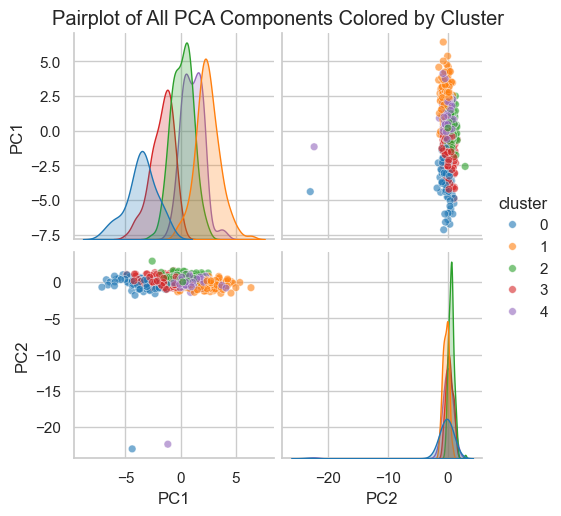

In [18]:
# Visualize clusters using all PCA components (pairplot)
pcs_df = pd.DataFrame(X_scaled, columns=features)
for i in range(pca.n_components_):
    pcs_df[f'PC{i+1}'] = pca.transform(X_scaled)[:, i]
pcs_df['cluster'] = df[cluster_col]

# Plot pairplot of all principal components colored by cluster
pc_cols = [f'PC{i+1}' for i in range(pca.n_components_)]
sns.pairplot(pcs_df, vars=pc_cols, hue='cluster', palette='tab10', plot_kws={'alpha': 0.6, 's': 30})
plt.suptitle('Pairplot of All PCA Components Colored by Cluster', y=1.02)
plt.show()

In [19]:
# Cell: Show per-cluster CSV samples and counts
from pathlib import Path
cdir = Path('data') / 'clusters'
if cdir.exists():
    for p in sorted(cdir.glob('cluster_*.csv')):
        sub = pd.read_csv(p)
        print(p.name, 'rows=', len(sub))
        display(sub.head(5))
else:
    print('data/clusters not found; run scripts/sort_players_by_cluster.py to generate')

data/clusters not found; run scripts/sort_players_by_cluster.py to generate
